In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [3]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/OH/Prong2/OH_prison_p2_model_inputs.yaml')
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_policy([], 'prison')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 480 results
transitions_data returned 50 results
total_population_data returned 480 results


In [4]:
outs = test_sim.data_dict['outflows_data'][test_sim.data_dict['outflows_data'].time_step == test_sim.data_dict['outflows_data'].time_step.max()]


initialization time:  93.11583924293518
simulation_time:  87.06411600112915
initialization time:  91.85000705718994
simulation_time:  84.25852274894714


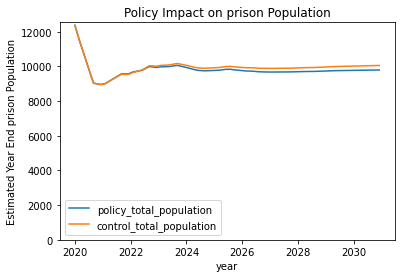

In [11]:
# Policy Option Method
possession_to_trafficking_diversion_rate = 0.10
felony_level_diversion_rate = 0.10

def get_felony_tag(felony_level):
    return f"F-{felony_level}"


def divert_felony_level(felony_level):
    felony_tag = get_felony_tag(felony_level)
    incoming_felony_tag = get_felony_tag(felony_level - 1)
    scale_factor = 0
    starting_size = outs[outs.crime == felony_tag].iloc[0].total_population
    if felony_level > 1:
        scale_factor -= felony_level_diversion_rate * outs[outs.crime == incoming_felony_tag].iloc[0].total_population / starting_size
    if felony_level < 5:
        scale_factor += felony_level_diversion_rate   
            
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=scale_factor,
                   outflow='prison')

policy_list = [SparkPolicy(policy_fn=divert_felony_level(felony_level),
                            spark_compartment='pretrial',
                            sub_population={'crime': get_felony_tag(felony_level), 'crime_type': crime_type},
                            apply_retroactive=False)
                for felony_level in [1,2,3,4,5] for crime_type in outs.crime_type.unique()]

test_results = test_sim.simulate_policy(policy_list, 'prison')

In [12]:
simulation_tag = 'OH_prison_p2_10%'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [6]:
round(pd.Series([1,2,3.4]))

0    1.0
1    2.0
2    3.0
dtype: float64